In [ ]:
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [ ]:
TRAIN_SEQUENCE = open("train_set.txt").read().strip().replace("\n", "").replace("N","")
TEST_SEQUENCE = open("test_set.txt").read().strip().replace("\n", "").replace("N","")

In [ ]:
class MarkovChain:
    def __init__(self, n_lookback=1, vocab="ACGT"):
        assert n_lookback > 0

        self.letter_to_idx = {x: i for i, x in enumerate(vocab)}
        self.state_to_idx = {"".join(p): i for i, p in enumerate(itertools.product(vocab, repeat=n_lookback))} # fmt: skip
        self.n_lookback = n_lookback
        self.vocab_size = len(vocab)
        self.vocab = vocab

        m_dim = np.power(self.vocab_size, n_lookback)
        n_dim = self.vocab_size

        self.transition_matrix = np.zeros((m_dim, n_dim), dtype=np.float32)

    def train(self, sequence):
        assert len(sequence) >= self.n_lookback
        for i in range(self.n_lookback, len(sequence)):
            curr_state_idx = self.state_to_idx[sequence[i - self.n_lookback : i]]
            next_state_idx = self.letter_to_idx[sequence[i]]
            self.transition_matrix[curr_state_idx, next_state_idx] += 1.0

        # laplace smoothing, basically to avoid zeros probabilities
        self.transition_matrix += 1.0
        normalization = np.sum(self.transition_matrix, axis=1, keepdims=True)
        self.transition_matrix /= normalization

    def test(self, sequence, method):
        assert len(sequence) >= self.n_lookback
        correct_count = 0

        for i in range(self.n_lookback, len(sequence)):
            curr_state = sequence[i - self.n_lookback : i]
            next_state = sequence[i]
            if self.next_state(curr_state, method= method) == next_state: #where we decide if it's random or greedy
                correct_count += 1
        accuracy = correct_count / (len(sequence) - self.n_lookback)
        print(f"Accuracy: {accuracy:.4f}")

    def next_state(self, current_state, method="random"): #if nothing is passed, it will be random
        assert method in ["random", "greedy"]
        assert len(current_state) == self.n_lookback
        curr_state_idx = self.state_to_idx[current_state]

        if method == "random":
            next_state = np.random.choice(
                self.vocab_size, p=self.transition_matrix[curr_state_idx]
            )
        elif method == "greedy":
            next_state = np.argmax(self.transition_matrix[curr_state_idx])

        return self.vocab[next_state]

Training

In [ ]:
n = 11
print(f"markov chain with n_lookback={n}")

start_time = time.perf_counter()

model11th = MarkovChain(n_lookback=n, vocab="ACGT")
model11th.train(TRAIN_SEQUENCE)

end_time = time.perf_counter()
print(f"training time: {end_time-start_time:.6f} seconds")

markov chain with n_lookback=11
training time: 288.175620 seconds


In [ ]:
n = 12
print(f"markov chain with n_lookback={n}")

start_time = time.perf_counter()

model12th = MarkovChain(n_lookback=n, vocab="ACGT")
model12th.train(TRAIN_SEQUENCE)

end_time = time.perf_counter()
print(f"training time: {end_time-start_time:.6f} seconds")

markov chain with n_lookback=12
training time: 304.181764 seconds


Autoregressive (Generate the entire genetic sequence, using best model for each (Greedy N = 11, and Random N =12))

In [ ]:
def generate_and_evaluate(model, test_seq, method="greedy"):
	n = model.n_lookback
	context = test_seq[:n]
	correct = 0
	total = len(test_seq) - n
	generated = context  # start with the initial prefix

	for i in range(n, len(test_seq)):
		pred = model.next_state(context, method=method)
		generated += pred  # build the full generated sequence
		if pred == test_seq[i]:
			correct += 1
			context = context[1:] + pred

	accuracy = correct / total
	return accuracy, generated


FOR OUR RESULTS THESE ARE THE ONES THAT MATTER

In [ ]:
t0 = time.perf_counter()
greedy_acc, greedy_seq = generate_and_evaluate(model11th, TEST_SEQUENCE, method="greedy")
t1 = time.perf_counter()

random_acc, random_seq = generate_and_evaluate(model12th, TEST_SEQUENCE, method="random")
t2 = time.perf_counter()

print(f"greedy accuracy = {greedy_acc:.4f}, time: {t1-t0:.6f} seconds")
print(f"random accuracy = {random_acc:.4f}, time: {t2-t1:.6f} seconds")

greedy accuracy = 0.2191, time: 47.057729 seconds
random accuracy = 0.2638, time: 383.491080 seconds


In [ ]:
# save greedy sequence
with open("final_greedy_sequence.txt", "w") as f:
	f.write(greedy_seq)

# save random sequence
with open("final_random_sequence.txt", "w") as f:
	f.write(random_seq)

Sanity Check (YET AGAIN)

In [ ]:
n = 4
print(f"markov chain with n_lookback={n}")

start_time = time.perf_counter()

model4th = MarkovChain(n_lookback=n, vocab="ACGT")
model4th.train(TRAIN_SEQUENCE)

end_time = time.perf_counter()
print(f"training time: {end_time-start_time:.6f} seconds")

markov chain with n_lookback=4
training time: 171.249389 seconds


In [ ]:
t3 = time.perf_counter()
greedy_four_acc, greedy_four_seq = generate_and_evaluate(model4th, TEST_SEQUENCE, method="greedy")
t4 = time.perf_counter()

random_four_acc, random_four_seq = generate_and_evaluate(model4th, TEST_SEQUENCE, method="random")
t5 = time.perf_counter()

print(f"n = 4 greedy accuracy = {greedy_four_acc:.4f}, time: {t4-t3:.6f} seconds")
print(f"n = 4 random accuracy = {random_four_acc:.4f}, time: {t5-t4:.6f} seconds")

n = 4 greedy accuracy = 0.2905, time: 46.408098 seconds
n = 4 random accuracy = 0.2642, time: 368.854939 seconds


In [ ]:
model5th = MarkovChain(n_lookback=5, vocab="ACGT")
model5th.train(TRAIN_SEQUENCE)

greedy_five_acc, greedy_five_seq = generate_and_evaluate(model5th, TEST_SEQUENCE, method="greedy")
random_five_acc, random_five_seq = generate_and_evaluate(model5th, TEST_SEQUENCE, method="random")

print(f"n = 5 greedy accuracy = {greedy_five_acc:.4f}")
print(f"n = 5 random accuracy = {random_five_acc:.4f}")

In [ ]:
greedy_eleven_acc, greedy_eleve_seq = generate_and_evaluate(model11th, TEST_SEQUENCE, method="greedy")
random_eleven_acc, random_eleven_seq = generate_and_evaluate(model11th, TEST_SEQUENCE, method="random")

print(f"n = 11 greedy accuracy = {greedy_eleven_acc:.4f}")
print(f"n = 11 random accuracy = {random_eleven_acc:.4f}")

n = 11 greedy accuracy = 0.2191
n = 11 random accuracy = 0.2663


In [ ]:
greedy_twelve_acc, greedy_twelve_seq = generate_and_evaluate(model12th, TEST_SEQUENCE, method="greedy")
random_twelve_acc, random_twelve_seq = generate_and_evaluate(model12th, TEST_SEQUENCE, method="random")

print(f"n = 12 greedy accuracy = {greedy_twelve_acc:.4f}")
print(f"n = 12 random accuracy = {random_twelve_acc:.4f}")

n = 12 greedy accuracy = 0.2182
n = 12 random accuracy = 0.2639


Perplexity

In [ ]:
import math

def compute_perplexity(model, sequence):
    N = model.n_lookback
    log2_prob_sum = 0
    T = len(sequence) - N
    for i in range(N, len(sequence)):
        context = sequence[i-N:i]
        true_base = sequence[i]
        ctx_idx = model.state_to_idx[context]
        base_idx = model.letter_to_idx[true_base]
        p = model.transition_matrix[ctx_idx, base_idx]

        # for tiny rounding zeros

        log2_prob_sum += math.log2(p if p > 0 else 1e-12)

    H = -log2_prob_sum/T # bits per symbol (cross entropy)
    return 2**H # pp

# pp = compute_perplexity(model11th, TEST_SEQUENCE)
# print(f"perplexity for n = 11 model: {pp:.2f}")

pp = compute_perplexity(model11th, TEST_SEQUENCE)
print(f"perplexity for n = 11 model: {pp:.2f}")
pp = compute_perplexity(model12th, TEST_SEQUENCE)
print(f"perplexity for n = 12 model: {pp:.2f}")

# oops i should've saved it with different variable names

Sanity check part two

In [ ]:
# bug found oops, the rows don't add up to one in my class saved transition matrix
# the transition matrix of model11th was off??? maybe is because i ran the code yesterday
row_sums = model11th.transition_matrix.sum(axis = 1)
print(row_sums.min(), row_sums.max())
# float imprecision error makes it 0.9999999 1.0000001
row_sums = model12th.transition_matrix.sum(axis = 1)
print(row_sums.min(), row_sums.max())

0.9999999 1.0000001
0.9999999 1.0000001


Graphs, Graphs, Graphs;

This one is the rather basic information we can extract (using training time, random time and accuracy, and greedy time and accuracy)
Not sure if we should use the trianing time (matter of space on poster)

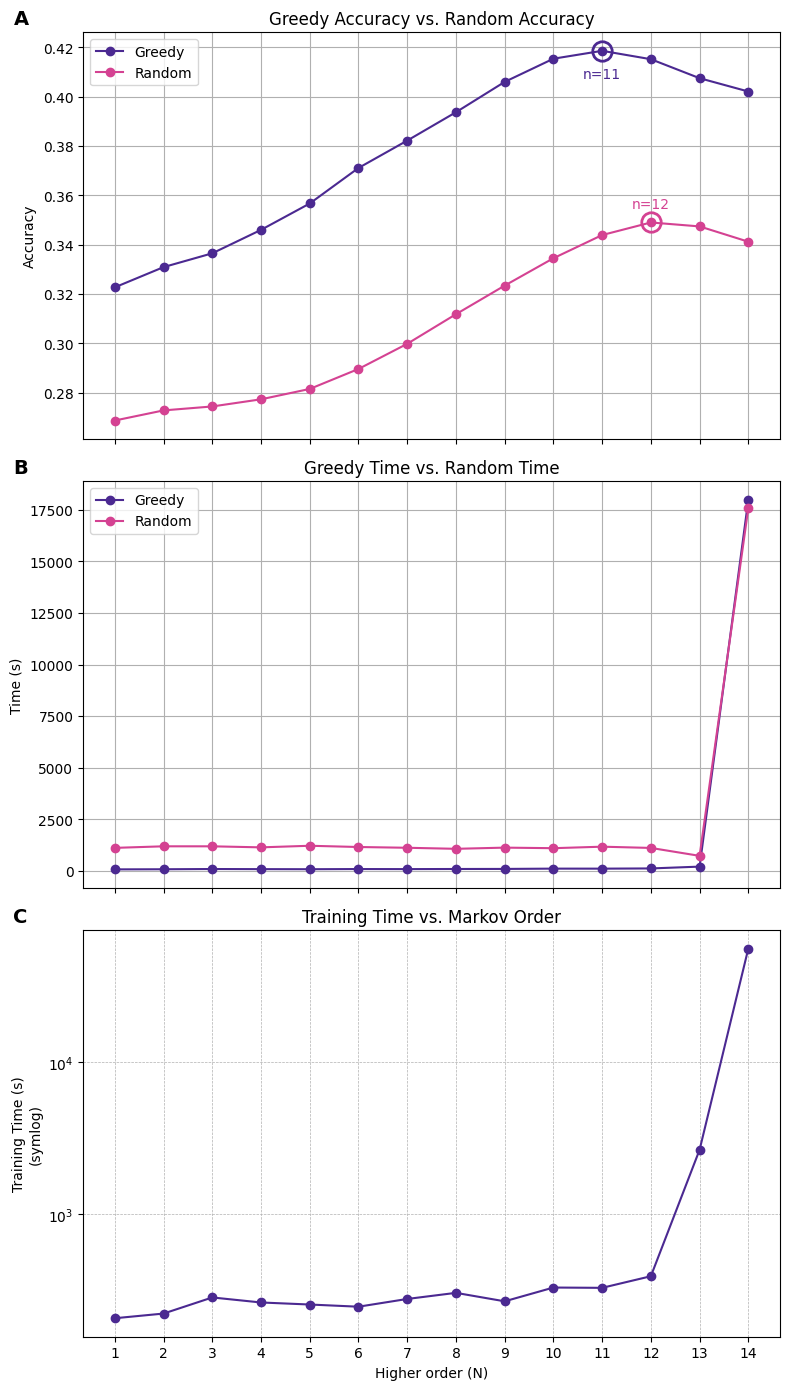

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# data for n=1 to n=14
n = np.arange(1, 15)
greedy_acc = np.array([0.3227, 0.3309, 0.3365, 0.3460, 0.3567, 0.3711, 0.3822,
                   	0.3937, 0.4060, 0.4154, 0.4186, 0.4152, 0.4075, 0.4021])

random_acc = np.array([0.2687, 0.2728, 0.2744, 0.2773, 0.2815, 0.2896, 0.2998,
                   	0.3118, 0.3234, 0.3345, 0.3439, 0.3490, 0.3474, 0.3412])

greedy_time = np.array([85.048331, 90.618003, 102.470040, 96.647125, 92.564059,
                    	100.838103, 97.841454, 103.818538, 106.809791, 121.079561,
                    	120.255649, 130.246325, 218.580150, 17981.015668])
random_time = np.array([1125.965898, 1201.684862, 1201.236312, 1150.895517,
                    	1228.239511, 1167.986255, 1131.172991, 1080.327514,
                    	1137.700348, 1110.646820, 1183.522887, 1123.140312,
                    	740.219882, 17571.955664])
training_time = np.array([326.265140, 340.125438, 387.861351, 372.971147,
                      	366.911447, 360.438810, 383.395805, 401.497911,
                      	376.428118, 417.244455, 416.361439, 450.780593,
                      	2644.825032, 55960.794100])

# three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharex=True)

# panel A: Greedy vs. Random Accuracy with peaks highlighted
ax = axes[0]
ax.plot(n, greedy_acc, marker='o', label='Greedy', color='#4b2991')
ax.plot(n, random_acc, marker='o', label='Random', color='#d44292')
i_g = np.argmax(greedy_acc)
i_r = np.argmax(random_acc)
# highlight peaks
ax.plot(n[i_g], greedy_acc[i_g],
     	marker='o', markersize=14, markerfacecolor='none',
     	markeredgecolor='#4b2991', markeredgewidth=2)
ax.plot(n[i_r], random_acc[i_r],
     	marker='o', markersize=14, markerfacecolor='none',
     	markeredgecolor='#d44292', markeredgewidth=2)
# annotate peak n values
ax.annotate(f'n={n[i_g]}', (n[i_g], greedy_acc[i_g]),
         	textcoords="offset points", xytext=(0, -20), ha='center', color='#4b2991')
ax.annotate(f'n={n[i_r]}', (n[i_r], random_acc[i_r]),
         	textcoords="offset points", xytext=(0, 10), ha='center', color='#d44292')
ax.set_ylabel('Accuracy')
ax.set_title('Greedy Accuracy vs. Random Accuracy')
ax.legend()
ax.grid(True)
ax.text(-0.1, 1.02, 'A', transform=ax.transAxes, fontsize=14, fontweight='bold')

# panel B: Greedy vs. Random Time (linear)
ax = axes[1]
ax.plot(n, greedy_time, marker='o', label='Greedy', color='#4b2991')
ax.plot(n, random_time, marker='o', label='Random', color='#d44292')
ax.set_ylabel('Time (s)')
ax.set_title('Greedy Time vs. Random Time')
ax.legend()
ax.grid(True)
ax.text(-0.1, 1.02, 'B', transform=ax.transAxes, fontsize=14, fontweight='bold')

# panel C: Training Time vs. Markov Order (symlog scale)
ax = axes[2]
ax.plot(n, training_time, marker='o', color='#4b2991')
ax.set_yscale('symlog', linthresh=500)
ax.set_xlabel('Higher order (N)')
ax.set_ylabel('Training Time (s)\n(symlog)')
ax.set_title('Training Time vs. Markov Order')
ax.grid(True, which='both', ls='--', lw=0.5)
ax.text(-0.1, 1.02, 'C', transform=ax.transAxes, fontsize=14, fontweight='bold')

axes[2].set_xticks(n)
axes[2].set_xticklabels(n)

plt.tight_layout()
plt.show()


In [ ]:
#greedy accuracy = 0.2191, time: 47.057729 seconds
#random accuracy = 0.2638, time: 383.491080 seconds



State Diagram Training

In [ ]:
class UpdatedMarkovChain:
    def __init__(self, n_lookback=1, vocab="ACGT"):
        assert n_lookback > 0

        self.letter_to_idx = {x: i for i, x in enumerate(vocab)}
        self.state_to_idx = {"".join(p): i for i, p in enumerate(itertools.product(vocab, repeat=n_lookback))} # fmt: skip
        self.n_lookback = n_lookback
        self.vocab_size = len(vocab)
        self.vocab = vocab

        m_dim = np.power(self.vocab_size, n_lookback)
        n_dim = self.vocab_size

        self.transition_matrix = np.zeros((m_dim, n_dim), dtype=np.float32)

    def train(self, sequence):
        assert len(sequence) >= self.n_lookback
        for i in range(self.n_lookback, len(sequence)):
            curr_state_idx = self.state_to_idx[sequence[i - self.n_lookback : i]]
            next_state_idx = self.letter_to_idx[sequence[i]]
            self.transition_matrix[curr_state_idx, next_state_idx] += 1.0

In [ ]:
model2updated = UpdatedMarkovChain(n_lookback=2, vocab="ACGT")
model2updated.train(TRAIN_SEQUENCE)

/var/folders/gw/pwjfwz495hq6vhdtnpwmhlkc0000gn/T/ipykernel_99482/736184191.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", len(communities))
/var/folders/gw/pwjfwz495hq6vhdtnpwmhlkc0000gn/T/ipykernel_99482/736184191.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


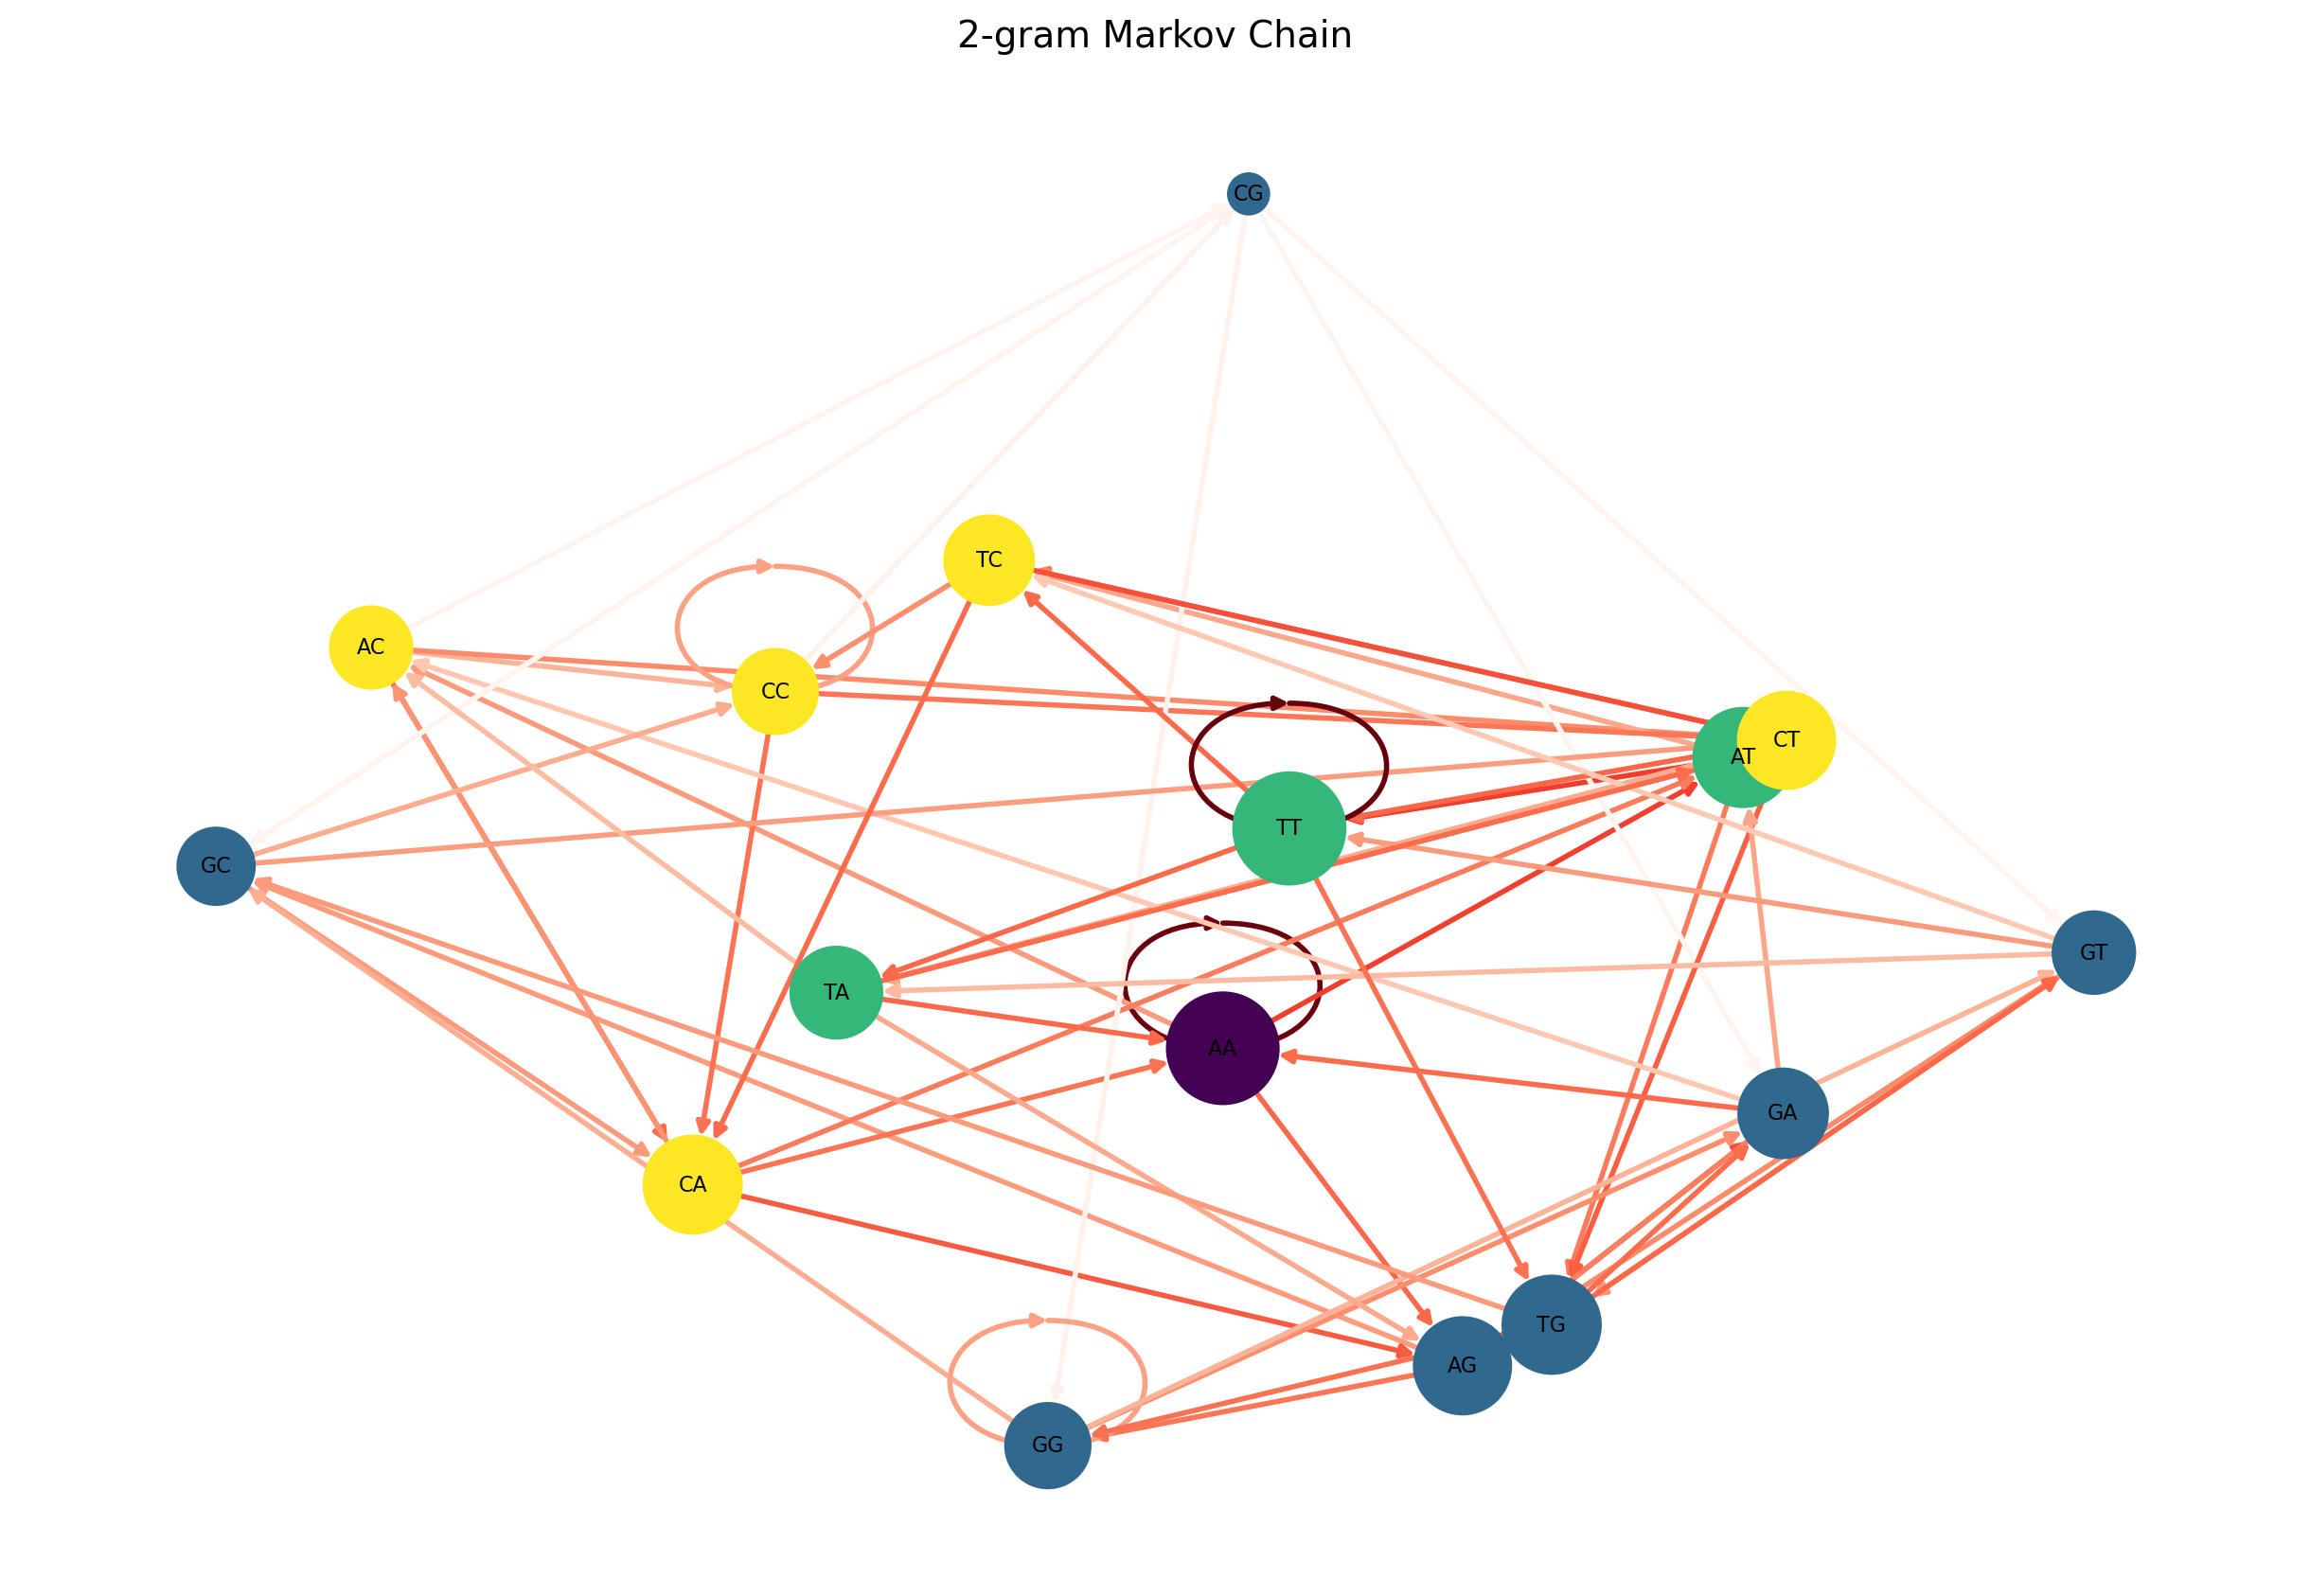

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
from networkx.algorithms.community import louvain_communities


def visualize_markov_chain_simple(mc, min_transition_fraction=0.05):
    G = nx.DiGraph()

    idx_to_state = {v: k for k, v in mc.state_to_idx.items()}
    idx_to_letter = {v: k for k, v in mc.letter_to_idx.items()}

    node_frequencies = {}

    # Build graph
    for i in range(mc.transition_matrix.shape[0]):
        from_kmer = idx_to_state[i]
        row_total = mc.transition_matrix[i].sum()
        if row_total == 0:
            continue
        node_frequencies[from_kmer] = row_total
        for j in range(mc.transition_matrix.shape[1]):
            count = mc.transition_matrix[i, j]
            if count == 0:
                continue
            frac = count / row_total
            if frac < min_transition_fraction:
                continue
            next_base = idx_to_letter[j]
            to_kmer = from_kmer[1:] + next_base if mc.n_lookback > 1 else next_base
            G.add_edge(from_kmer, to_kmer, weight=count)

    if G.number_of_nodes() == 0:
        print("Graph is empty — check your data or threshold.")
        return

    # Community detection
    communities = louvain_communities(G.to_undirected(), weight="weight", seed=42)
    community_map = {node: i for i, comm in enumerate(communities) for node in comm}
    cmap = cm.get_cmap("viridis", len(communities))

    # Get number of nodes
    num_nodes = len(G.nodes())
    from math import sqrt

    # Layout
    pos = nx.spring_layout(
        G, weight="weight", seed=42, k=20/ sqrt(num_nodes), iterations=100
    )

    # Node properties
    max_freq = max(node_frequencies.values(), default=1)
    node_sizes = [
        50 + 2.5 * 700 * (node_frequencies.get(node, 0) / max_freq)
        for node in G.nodes()
    ]
    node_colors = [cmap(community_map.get(node, 0)) for node in G.nodes()] # will probably get rid of colors

    # Edge properties
    edge_weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    edge_norm = colors.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max())
    edge_colors = [cm.Reds(edge_norm(G[u][v]["weight"])) for u, v in G.edges()]

    # Draw everything
    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color=edge_colors,
        edge_cmap=cm.Reds,
        font_size=8,
        alpha=1.0,
        width=2,
    )
    plt.title(f"{mc.n_lookback}-gram Markov Chain", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_markov_chain_simple(model2updated, min_transition_fraction=0.05)